In [1]:
# Common lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# sklearn
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, average_precision_score

# Tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utilities
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
!unzip drive/MyDrive/x_ray*

In [3]:
vgg_file = 'drive/MyDrive/models/best_vgg16_2.hdf5'
resnet_file = 'drive/MyDrive/models/best_resnet18_2.hdf5'

In [4]:
input_folder = './x_ray_corona_dataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

train_batches = ImageDataGenerator().flow_from_dataframe(train_df,
                                                         directory=train_img_folder,
                                                         x_col='X_ray_image_name',
                                                         y_col='Label',
                                                         class_mode='binary',
                                                         batch_size=128,
                                                         target_size=(224, 224),
                                                         shuffle=False)

test_batches = ImageDataGenerator().flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=128,
                                            target_size=(224, 224),
                                            shuffle=False)

Shape of train data: (5286, 5)
Shape of test data: (624, 5)
Found 5286 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [5]:
vgg = load_model(vgg_file)
resnet = load_model(resnet_file)

In [6]:
y_true = test_batches.classes
vgg_y_probs = vgg.predict(test_batches)
resnet_y_probs = resnet.predict(test_batches)

# Plot PR curve by PLT

In [7]:
def plot_pr_curve(n_models, model_info):
  """
  Plot Precision-Recall curve of n models.
  Arg:
    n_models (int): number of models wanna plot.
    model_info (list): list contains model tuple (y_true, y_probs, model_name)
  """

  plt.figure(figsize=(8, 6))
  for i in range(n_models):
    true_prob_name = model_info[i]
    y_true = true_prob_name[0]
    y_prob = true_prob_name[1]
    name = true_prob_name[2]
    precision, recall, threshold = precision_recall_curve(y_true, y_prob)
    auc_score = auc(recall, precision)
    auc_score = float("{:.4f}".format(auc_score))
    label = name + ' (AUC - ' + str(auc_score) + ')'

    # Plot pr curve
    plt.plot(recall, precision, marker='.', label=label, linewidth='1', markersize='3')
  
  # Update layout
  plt.plot([0, 1], [1, 0], linestyle='--', color='black')
  plt.xlabel('Recall', size=13)
  plt.ylabel('Precision', size=13)
  plt.legend(fontsize='large')
  plt.show()

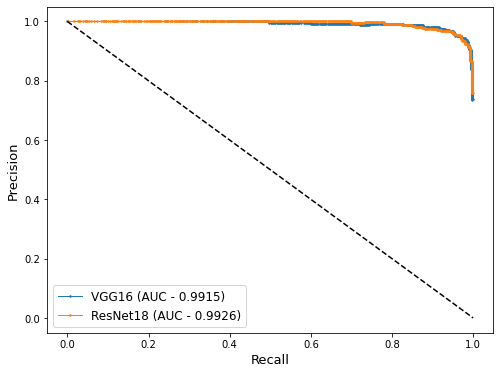

In [8]:
plot_pr_curve(2, [(y_true, vgg_y_probs, 'VGG16'), (y_true, resnet_y_probs, 'ResNet18')])

# Plot PR Curve by Plotly

## Example

In [9]:
resnet_precision, resnet_recall, resnet_threshold = precision_recall_curve(y_true, resnet_y_probs)

fig = px.area(
    x=resnet_recall, y=resnet_precision,
    title=f'ResNet18 (AUC={auc(resnet_recall, resnet_precision):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

## PR curve of 2 models

In [10]:
def plot_pr_curve(n_models, model_info):
  """
  Plot Precision-Recall curve of n models.
  Arg:
    n_models (int): number of models wanna plot.
    model_info (list): list contains model tuple (y_true, y_probs, model_name)
  """

  # Create empty figure
  fig = go.Figure()
  fig.add_shape(
      type='line', line=dict(dash='dash'),
      x0=0, x1=1, y0=1, y1=0
  )

  for i in range(n_models):
    # Get info of model
    true_prob_name = model_info[i]
    y_true = true_prob_name[0]
    y_prob = true_prob_name[1]
    name = true_prob_name[2]
    precision, recall, threshold = precision_recall_curve(y_true, y_prob)
    auc_score = auc(recall, precision)
    auc_score = float("{:.4f}".format(auc_score))
    label = name + ' (AUC - ' + str(auc_score) + ')'

    # Plot pr curve
    fig.add_trace(go.Scatter(x=recall, 
                             y=precision, 
                             mode='lines', 
                             name=label,
                             line_width=2.5))

    # Update layout
    fig.update_layout(
    xaxis_title='Recall',
    yaxis_title='Precision',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
  )
  fig.show()

In [11]:
plot_pr_curve(2, [(y_true, vgg_y_probs, 'VGG16'), (y_true, resnet_y_probs, 'ResNet18')])

# Find optimal threshold for P-R Curve


In [12]:
def find_optimal_threshold(y_true, y_prob):
  """
  Find best threshold of model.
  Args:
    y_true (list): list of ground truth labels.
    y_prob (list): list of probabilities.
  Return:
    fscore_best (float): best fscore computed by best precision and recall.
    threshold_best (float): optimal threshold to classify.
  """

  # Compute precision, recall, threshold
  precision, recall ,threshold = precision_recall_curve(y_true, y_prob)

  # Convert to f1_score
  fscore = (2 * precision * recall) / (precision + recall)

  # Find position of the largest f1_score
  idx_best_fscore = np.argmax(fscore)
  print('Precision best: ', precision[idx_best_fscore])
  print('Recall best: ', recall[idx_best_fscore])
  # Return the best threshold and f1_score
  return threshold[idx_best_fscore], fscore[idx_best_fscore]

In [13]:
vgg_threshold_best, vgg_fscore_best = find_optimal_threshold(y_true, 
                                                             vgg_y_probs)
print('VGG16: Best threshold: {:.4f} - Best F1: {:.4f}'.format(vgg_threshold_best, 
                                                               vgg_fscore_best))

Precision best:  0.9388753056234719
Recall best:  0.9846153846153847
VGG16: Best threshold: 0.7134 - Best F1: 0.9612


In [14]:
resnet_threshold_best, resnet_fscore_best = find_optimal_threshold(y_true, 
                                                                   resnet_y_probs)
print('ResNet18: Best threshold: {:.4f} - Best F1: {:.4f}'.format(resnet_threshold_best, 
                                                               resnet_fscore_best))

Precision best:  0.9521410579345088
Recall best:  0.9692307692307692
ResNet18: Best threshold: 0.8163 - Best F1: 0.9606


# Confusion matrix

In [23]:
def to_label(y_prob, threshold):
  """
  Convert probability to label.
  Args:
    y_prob (list, ndarray): list of probabilities.
    threshold (float): threshold to classify.
  Return:
    y_predict (list): list of predict label.
  """

  y_predict = (y_prob >= threshold).astype('int')
  y_predict = np.reshape(y_predict, (-1))
  return y_predict

def plot_confusion_matrix(y_true, y_predict, model_name, color_map):
  """
  Plot confusion matrix.
  Args:
    y_true (list, ndarray): list of ground truth labels.
    y_predict (list, ndarray): list of predicted labels.
    model_name (string): model's name.
    color_map (obj): color the map.
  """

  label = ['Normal', 'Pneumonia']
  # Compute confusion matrix
  cf_matrix = confusion_matrix(y_true, y_predict)

  # Plot confusion matrix
  plt.figure(figsize=(8,5))
  plt.imshow(cf_matrix, cmap=color_map)
  plt.colorbar()
  for i in range(len(label)):
    for j in range(len(label)):
        plt.text(j, i, cf_matrix[i, j], 
                 horizontalalignment='center', 
                 verticalalignment='center', size=15)

  # Update layout
  plt.xticks([0, 1], label, size=12)
  plt.yticks([0, 1], label, size=12)
  plt.xlabel('Predicted label', size=14)
  plt.ylabel('True label', size=14)
  plt.title('Confusion matrix of ' + model_name, size=15)
  return cf_matrix

In [20]:
vgg_y_predict = to_label(vgg_y_probs, vgg_threshold_best)
resnet_y_predict = to_label(resnet_y_probs, resnet_threshold_best)

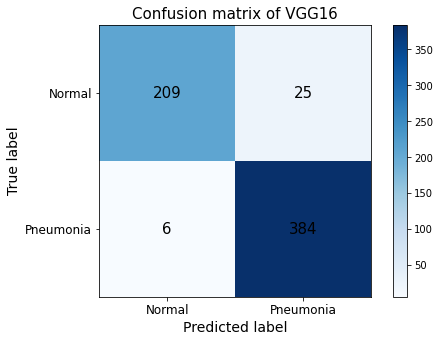

In [24]:
cf_matrix = plot_confusion_matrix(y_true, vgg_y_predict, 'VGG16', plt.cm.Blues)

array([[215,  19],
       [ 12, 378]])

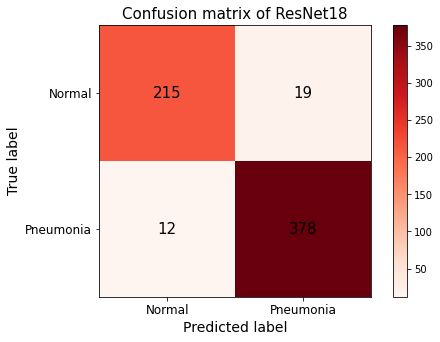

In [25]:
plot_confusion_matrix(y_true, resnet_y_predict, 'ResNet18', plt.cm.Reds)